In [346]:
from __future__ import division
import vertica_python
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
from vertica_python import connect
import StringIO
from StringIO import StringIO
from datetime import date, timedelta as td
import xlsxwriter
import os
import json
import urllib2
import base64
import datetime
%matplotlib inline
import matplotlib.pyplot as plt

import re
import csv
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import seaborn as sns
from dateutil import parser

In [2]:
import argparse

from apiclient.discovery import build
import httplib2
from oauth2client import client
from oauth2client import file
from oauth2client import tools

In [17]:
username = os.getenv('VERTICA_USERNAME')
password = os.getenv('VERTICA_PASSWORD')
conn_info = {'host': 'warehouse.analytics.edx.org',
             'port': 5433,
             'user': username,
             'password': password,
             'database': 'warehouse',
             'read_timeout': 600,
             'unicode_error': 'strict',
             'ssl': False}

In [3]:
def get_service(api_name, api_version, scope, client_secrets_path):
  """Get a service that communicates to a Google API.

  Args:
    api_name: string The name of the api to connect to.
    api_version: string The api version to connect to.
    scope: A list of strings representing the auth scopes to authorize for the
      connection.
    client_secrets_path: string A path to a valid client secrets file.

  Returns:
    A service that is connected to the specified API.
  """
  # Parse command-line arguments.
  parser = argparse.ArgumentParser(
      formatter_class=argparse.RawDescriptionHelpFormatter,
      parents=[tools.argparser])
  flags = parser.parse_args([])

  # Set up a Flow object to be used if we need to authenticate.
  flow = client.flow_from_clientsecrets(
      client_secrets_path, scope=scope,
      message=tools.message_if_missing(client_secrets_path))

  # Prepare credentials, and authorize HTTP object with them.
  # If the credentials don't exist or are invalid run through the native client
  # flow. The Storage object will ensure that if successful the good
  # credentials will get written back to a file.
  storage = file.Storage(api_name + '.dat')
  credentials = storage.get()
  if credentials is None or credentials.invalid:
    credentials = tools.run_flow(flow, storage, flags)
  http = credentials.authorize(http=httplib2.Http())

  # Build the service object.
  service = build(api_name, api_version, http=http)

  return service

In [6]:
scope = ['https://www.googleapis.com/auth/analytics.readonly']
service = get_service('analytics', 'v3', scope, 'client_secrets.json')

In [173]:
out = service.data().ga().get(
    ids='ga:' + '86300562',
    start_date=str('2016-01-01'),
    end_date=str('2016-12-31'),
    max_results=10000,
    dimensions='ga:date',
    metrics='ga:sessions').execute()

col_list = []

for i in np.arange(0,len(out['columnHeaders'])):
    line = re.sub('ga.', '', out['columnHeaders'][i][u'name'])
    col_list.append(line)
    
ga_sessions_df = pd.DataFrame(out['rows'],columns=col_list)

In [174]:
enroll_query = """
SELECT
    date(first_enrollment_time) AS date,
    COUNT(1) AS cnt_enrolls
FROM
    production.d_user_course
WHERE
    first_enrollment_time BETWEEN '2016-01-01' AND '2016-12-31'
GROUP BY 1
"""

reg_query = """
SELECT
    date(user_account_creation_time) AS date,
    COUNT(1) AS cnt_registrations
FROM
    production.d_user
WHERE
    user_account_creation_time BETWEEN '2016-01-01' AND '2016-12-31'
GROUP BY 1
"""

In [175]:
connection = vertica_python.connect(**conn_info)

cur = connection.cursor('dict')
cur.execute(enroll_query)
extract = cur.fetchall()
enroll_df = pd.DataFrame(extract)

cur.execute(reg_query)
extract = cur.fetchall()
reg_df = pd.DataFrame(extract)

connection.close()

In [176]:
enroll_df['date'] = enroll_df.date.astype(str)
enroll_df['date'] = enroll_df.date.str.replace('-','')

reg_df['date'] = reg_df.date.astype(str)
reg_df['date'] = reg_df.date.str.replace('-','')

In [425]:
enroll_reg_sessions_merge = ga_sessions_df.merge(
    enroll_df.merge(
        reg_df, how='outer', on = ['date']),
            how='outer', on = ['date'])

In [280]:
enroll_reg_sessions_merge = enroll_reg_sessions_merge[enroll_reg_sessions_merge.date>='2016-10-01']

In [426]:
enroll_reg_sessions_merge['sessions'] = enroll_reg_sessions_merge.sessions.astype(int)
enroll_reg_sessions_merge['date'] = pd.to_datetime(enroll_reg_sessions_merge['date'])

In [427]:
enroll_reg_sessions_merge = enroll_reg_sessions_merge.set_index('date')
enroll_reg_sessions_merge['enrollment_conversion'] = enroll_reg_sessions_merge.cumsum()['cnt_enrolls'] * 100.0/enroll_reg_sessions_merge.cumsum()['sessions']
enroll_reg_sessions_merge['enrollment_conversion'] = pd.to_numeric(enroll_reg_sessions_merge['enrollment_conversion'])
enroll_reg_sessions_merge['reg_conversion'] = enroll_reg_sessions_merge.cumsum()['cnt_registrations'] * 100.0/enroll_reg_sessions_merge.cumsum()['sessions']
enroll_reg_sessions_merge['reg_conversion'] = pd.to_numeric(enroll_reg_sessions_merge['reg_conversion'])
enroll_reg_sessions_merge['enrollment_conversion_daily'] = enroll_reg_sessions_merge.cnt_enrolls*100.0/enroll_reg_sessions_merge.sessions
enroll_reg_sessions_merge['reg_conversion_daily'] = enroll_reg_sessions_merge.cnt_registrations*100.0/enroll_reg_sessions_merge.sessions

In [428]:
enroll_reg_sessions_merge = enroll_reg_sessions_merge.reset_index()

In [429]:
enroll_reg_sessions_merge

,date,sessions,cnt_enrolls,cnt_registrations,enrollment_conversion,reg_conversion,enrollment_conversion_daily,reg_conversion_daily
0,2016-01-01,158003,22300.0,4656,14.113656,2.946779,14.113656,2.946779
1,2016-01-02,192900,27775.0,6824,14.270325,3.271559,14.398652,3.537584
2,2016-01-03,220528,35092.0,10630,14.904162,3.869234,15.912719,4.820250
3,2016-01-04,288682,47701.0,13339,15.447738,4.121435,16.523718,4.620655
4,2016-01-05,308620,49441.0,12275,15.598858,4.083396,16.020025,3.977383
5,2016-01-06,311638,50790.0,12281,15.745985,4.053376,16.297756,3.940790
6,2016-01-07,281739,40467.0,11752,15.524910,4.072220,14.363294,4.171236
7,2016-01-08,261206,35228.0,10201,15.261778,4.050677,13.486673,3.905347
8,2016-01-09,217900,29903.0,7512,15.112198,3.992029,13.723268,3.447453
9,2016-01-10,227202,31057.0,8602,14.979392,3.973071,13.669334,3.786058


In [430]:
sns.set_context("poster")
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
xkcd = sns.xkcd_palette(colors)

In [431]:
quarters = [
    'FY2016_Q3',
    'FY2016_Q4',
    'FY2017_Q1',
    'FY2017_Q2',
    ''
]

In [292]:
months = [
    
    'October 2016',
    'November 2016',
    'December 2016',
    ''
    
]

/Users/adleyhemphill/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=7,center=False).mean()
  if __name__ == '__main__':


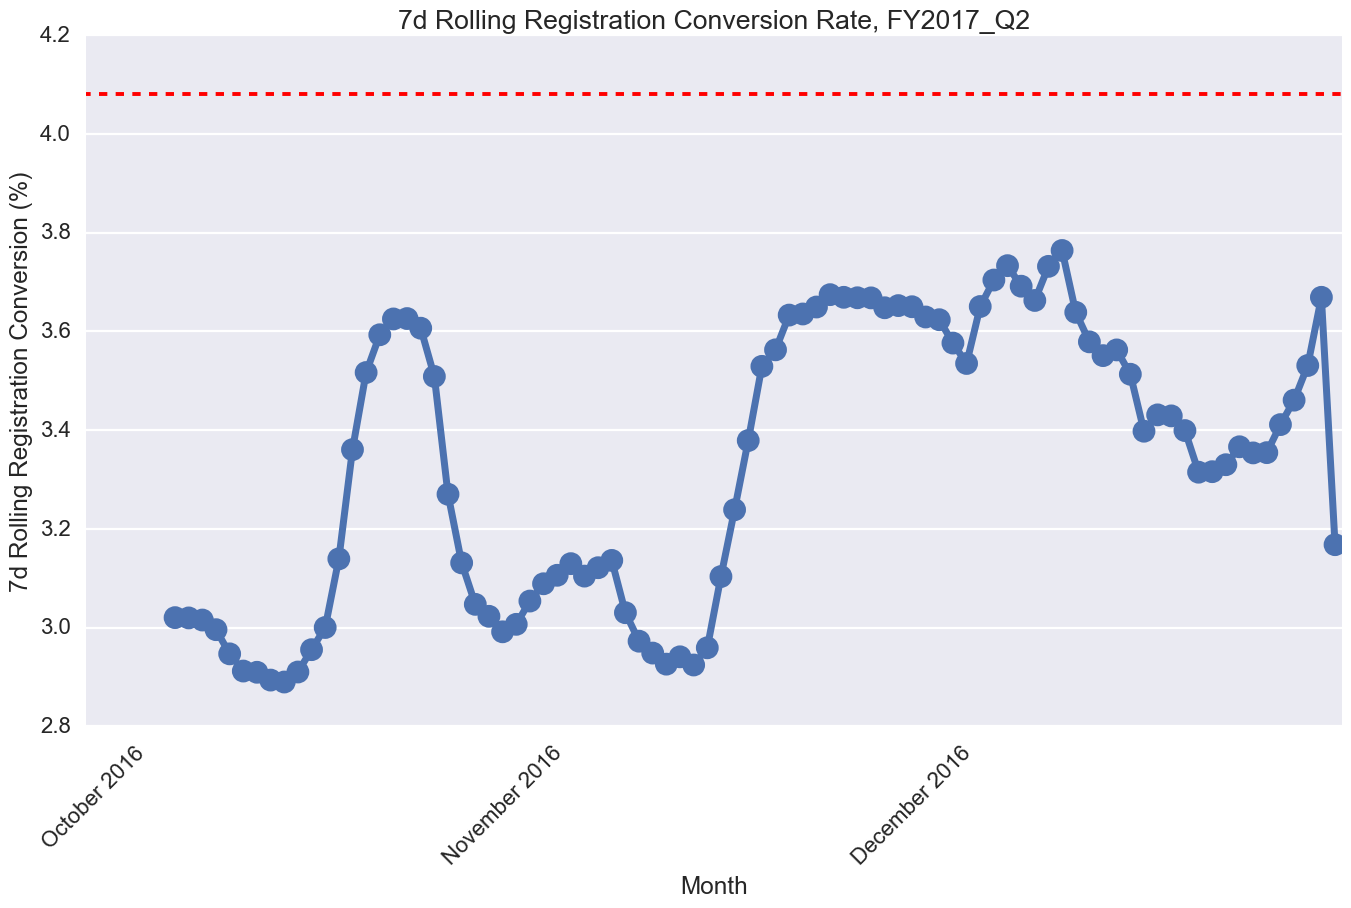

In [387]:
ax = sns.factorplot(data = pd.rolling_mean(enroll_reg_sessions_merge.set_index('date'), window=7).reset_index(),
                    x = 'date', y = 'reg_conversion_daily', 
               kind = 'point', size = 8, aspect = 2)
ax.set(xlabel='Month', ylabel='7d Rolling Registration Conversion (%)', 
       title = '7d Rolling Registration Conversion Rate, FY2017_Q2',
       xticks=np.arange(0,91,30), xticklabels=months)
ax.set_xticklabels(rotation=45)
plt.plot(np.linspace(-20,120,1000), [4.08]*1000, 'r--')

/Users/adleyhemphill/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=7,center=False).mean()
  if __name__ == '__main__':


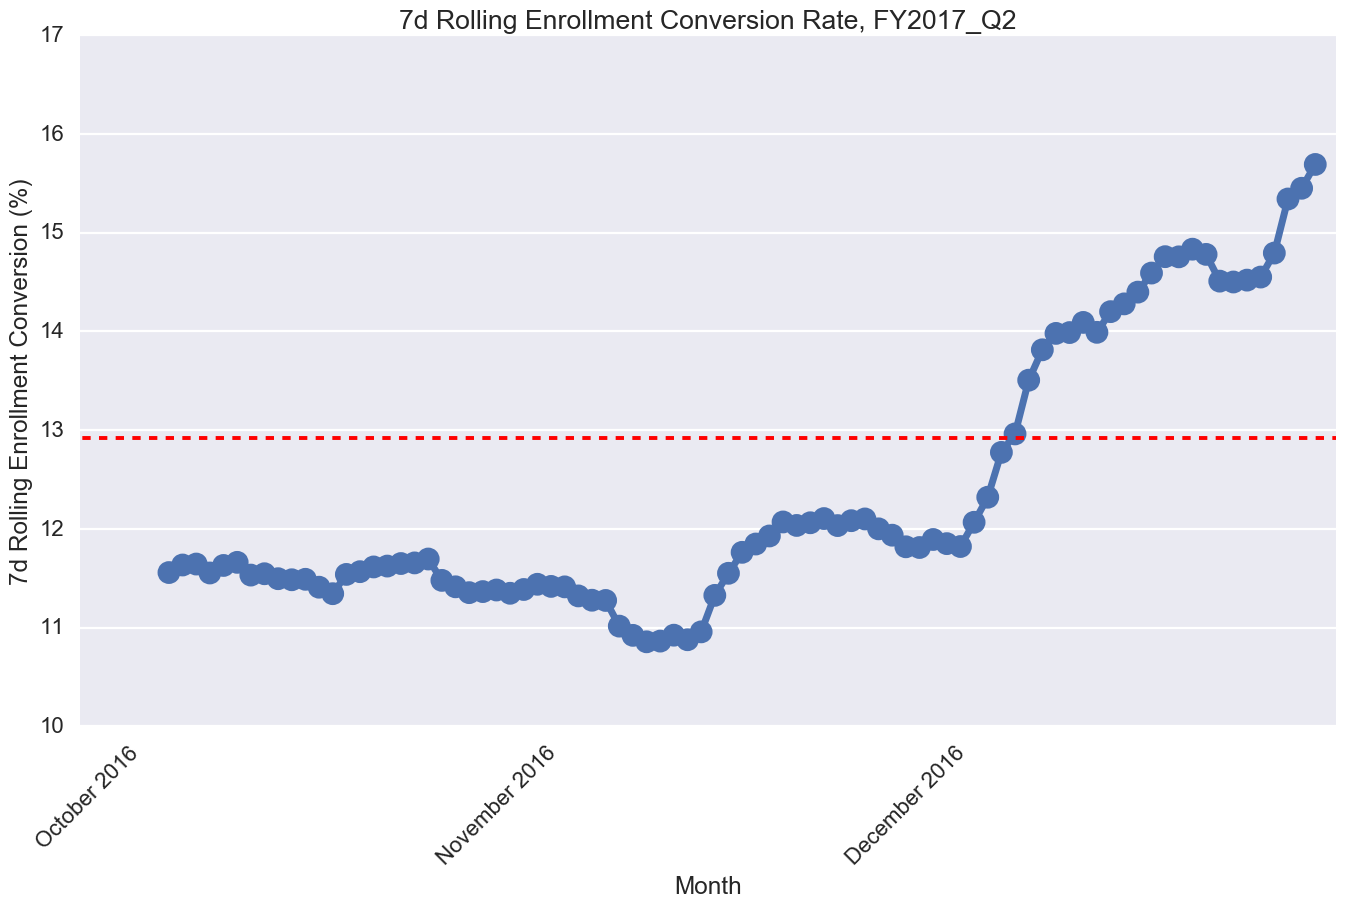

In [398]:
ax = sns.factorplot(data = pd.rolling_mean(enroll_reg_sessions_merge.set_index('date'), window=7).reset_index(),
                    x = 'date', y = 'enrollment_conversion_daily', 
               kind = 'point', size = 8, aspect = 2)
ax.set(xlabel='Month', ylabel='7d Rolling Enrollment Conversion (%)', 
       title = '7d Rolling Enrollment Conversion Rate, FY2017_Q2',
       xticks=np.arange(0,91,30), xticklabels=months)
ax.set_xticklabels(rotation=45)
plt.plot(np.linspace(-20,120,1000), [12.92]*1000, 'r--')

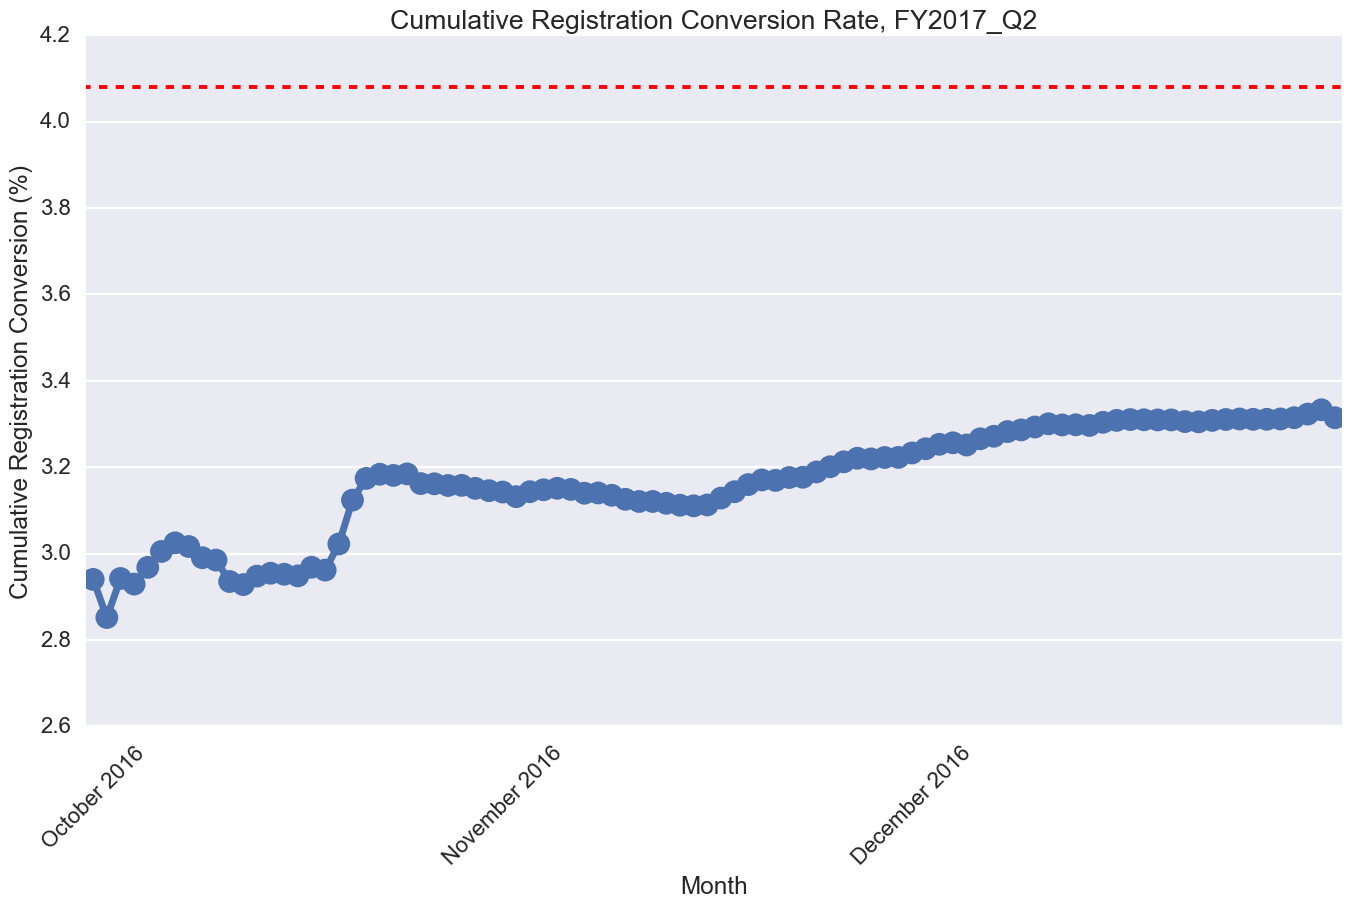

In [389]:
ax = sns.factorplot(data = enroll_reg_sessions_merge, x = 'date', y = 'reg_conversion', 
               kind = 'point', size = 8, aspect = 2)
ax.set(xlabel='Month', ylabel='Cumulative Registration Conversion (%)', 
       title = 'Cumulative Registration Conversion Rate, FY2017_Q2',
       xticks=np.arange(0,91,30), xticklabels=months)
ax.set_xticklabels(rotation=45)
plt.plot(np.linspace(-20,120,1000), [4.08]*1000, 'r--')

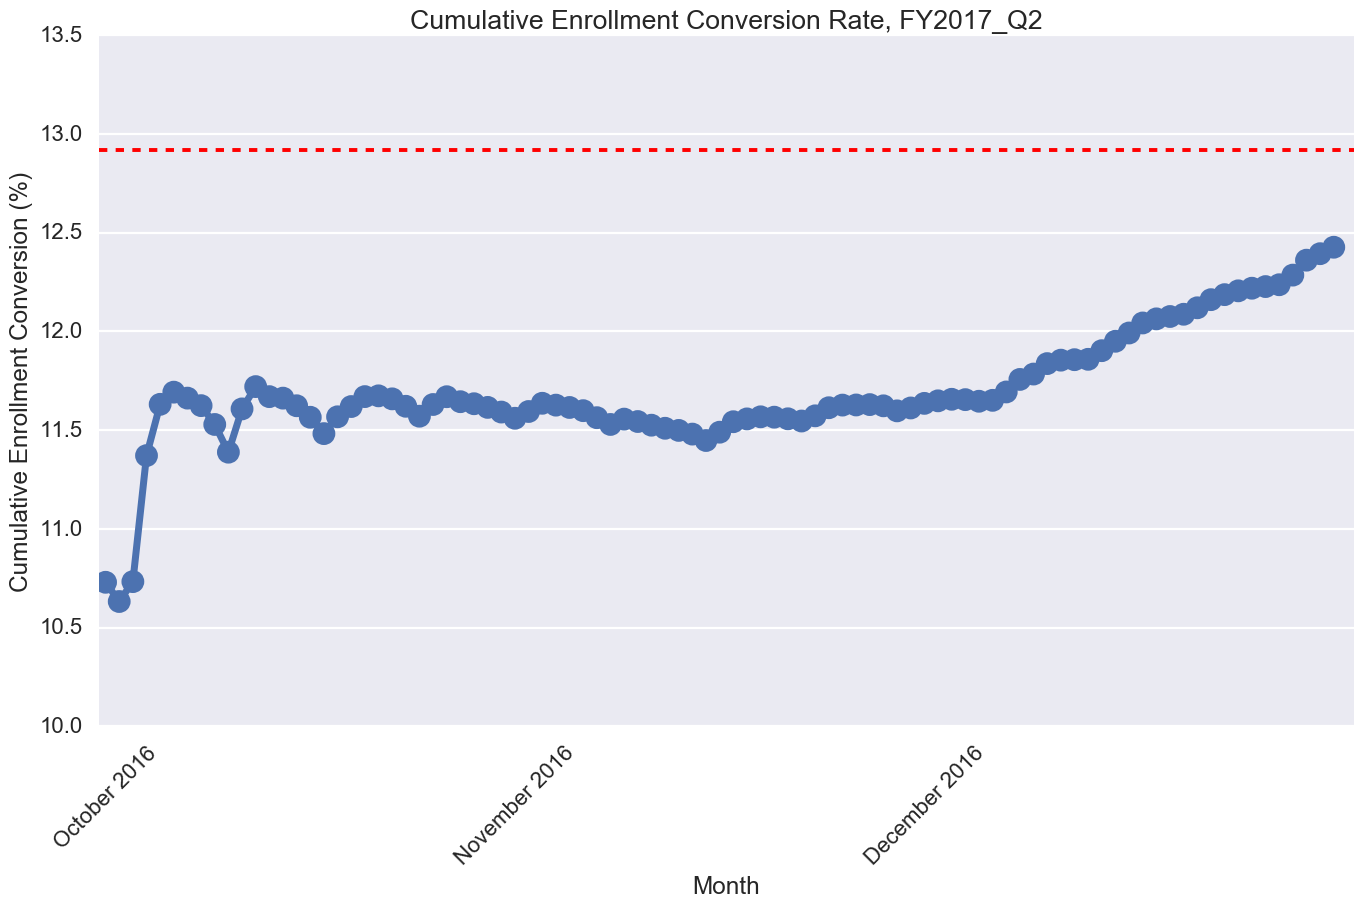

In [390]:
ax = sns.factorplot(data = enroll_reg_sessions_merge, x = 'date', y = 'enrollment_conversion', 
               kind = 'point', size = 8, aspect = 2)
ax.set(xlabel='Month', ylabel='Cumulative Enrollment Conversion (%)', 
       title = 'Cumulative Enrollment Conversion Rate, FY2017_Q2',
       xticks=np.arange(0,91,30), xticklabels=months)
ax.set_xticklabels(rotation=45)
plt.plot(np.linspace(-20,120,1000), [12.92]*1000, 'r--')

In [391]:
q2_sessions_projected = 27024141 
q2_sessions_projected_2 =   32235205
 

In [418]:
ga_sessions_q2 = ga_sessions_df[ga_sessions_df.date>='20161001']

In [419]:
ga_sessions_q2['projected_sessions'] = np.full(len(ga_sessions_q2),q2_sessions_projected_2)/len(ga_sessions_q2)
ga_sessions_q2['projected_sessions'] = pd.to_numeric(ga_sessions_q2['projected_sessions'])
ga_sessions_q2['sessions'] = pd.to_numeric(ga_sessions_q2['sessions'])

/Users/adleyhemphill/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/adleyhemphill/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/adleyhemphill/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [420]:
ga_sessions_q2_cumulative = ga_sessions_q2.set_index('date').cumsum().reset_index()

In [421]:
sns.set_context("poster")
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
xkcd = sns.xkcd_palette(colors)

In [422]:
ga_plot = ga_sessions_q2_cumulative.set_index('date').stack().reset_index()
ga_plot.head()

,date,level_1,0
0,20161001,sessions,258930.000000
1,20161001,projected_sessions,350382.663043
2,20161002,sessions,540576.000000
3,20161002,projected_sessions,700765.326087
4,20161003,sessions,903374.000000


In [423]:
ga_plot.rename(columns={'level_1': 'legend', 0: 'sessions'}, inplace=True)

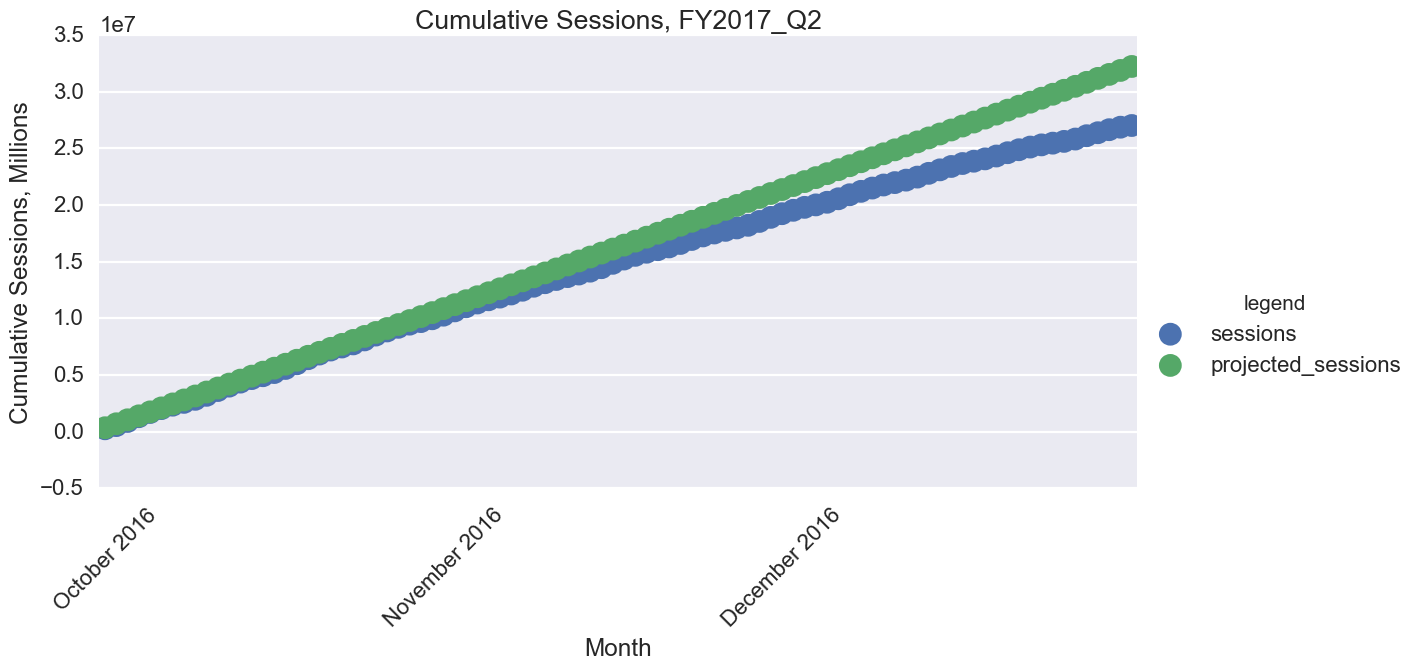

In [424]:
# fig, ax = plt.subplots()

ax = sns.factorplot(data = ga_plot, x = 'date', 
                    y = 'sessions', 
               kind = 'point',hue='legend', size = 6, aspect = 2)


ax.set(xlabel='Month', ylabel='Cumulative Sessions, Millions', 
       title = 'Cumulative Sessions, FY2017_Q2',
       xticks=np.arange(0,91,30), xticklabels=months)
ax.set_xticklabels(rotation=45)
#plt.plot(ga_sessions_q2.date, ga_sessions_q2.sessions, 'r--')

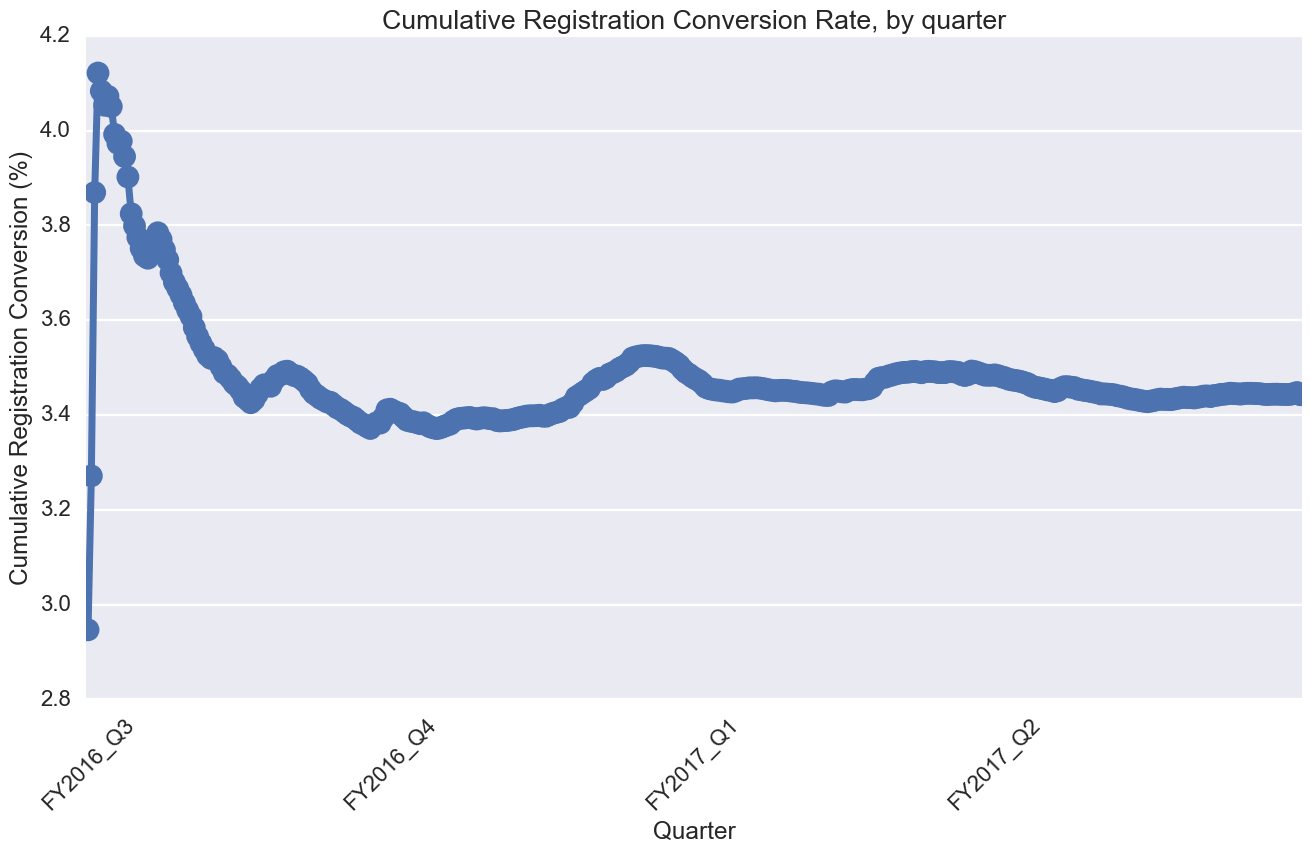

In [434]:
ax = sns.factorplot(data = enroll_reg_sessions_merge, x = 'date', y = 'reg_conversion', 
               kind = 'point', size = 8, aspect = 2)
ax.set(xlabel='Quarter', ylabel='Cumulative Registration Conversion (%)', 
       title = 'Cumulative Registration Conversion Rate, by quarter',
       xticks=np.arange(0,365,91), xticklabels=quarters)
ax.set_xticklabels(rotation=45)

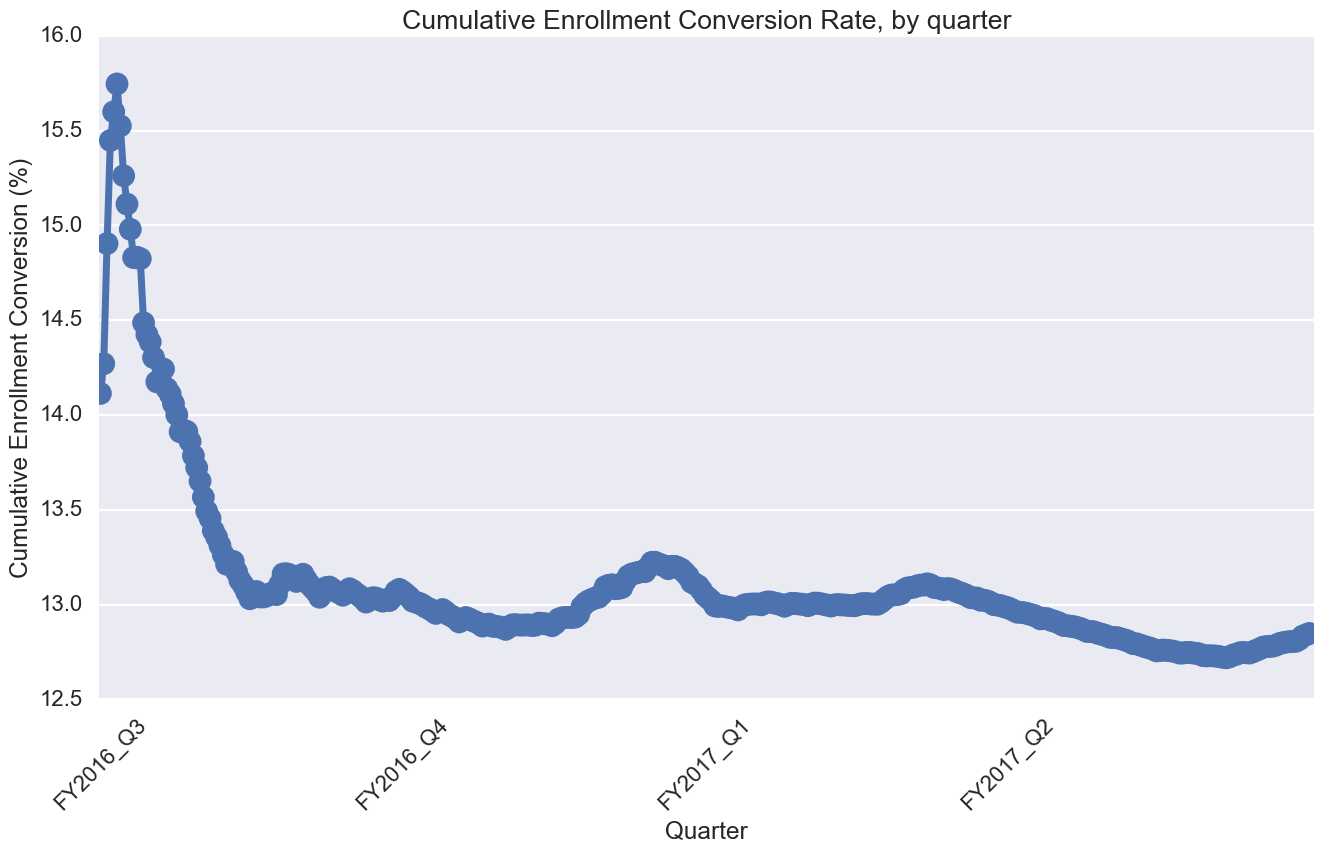

In [432]:
ax = sns.factorplot(data = enroll_reg_sessions_merge, x = 'date', y = 'enrollment_conversion', 
               kind = 'point', size = 8, aspect = 2)
ax.set(xlabel='Quarter', ylabel='Cumulative Enrollment Conversion (%)', 
       title = 'Cumulative Enrollment Conversion Rate, by quarter',
       xticks=np.arange(0,365,91), xticklabels=quarters)
ax.set_xticklabels(rotation=45)

/Users/adleyhemphill/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=7,center=False).mean()
  if __name__ == '__main__':


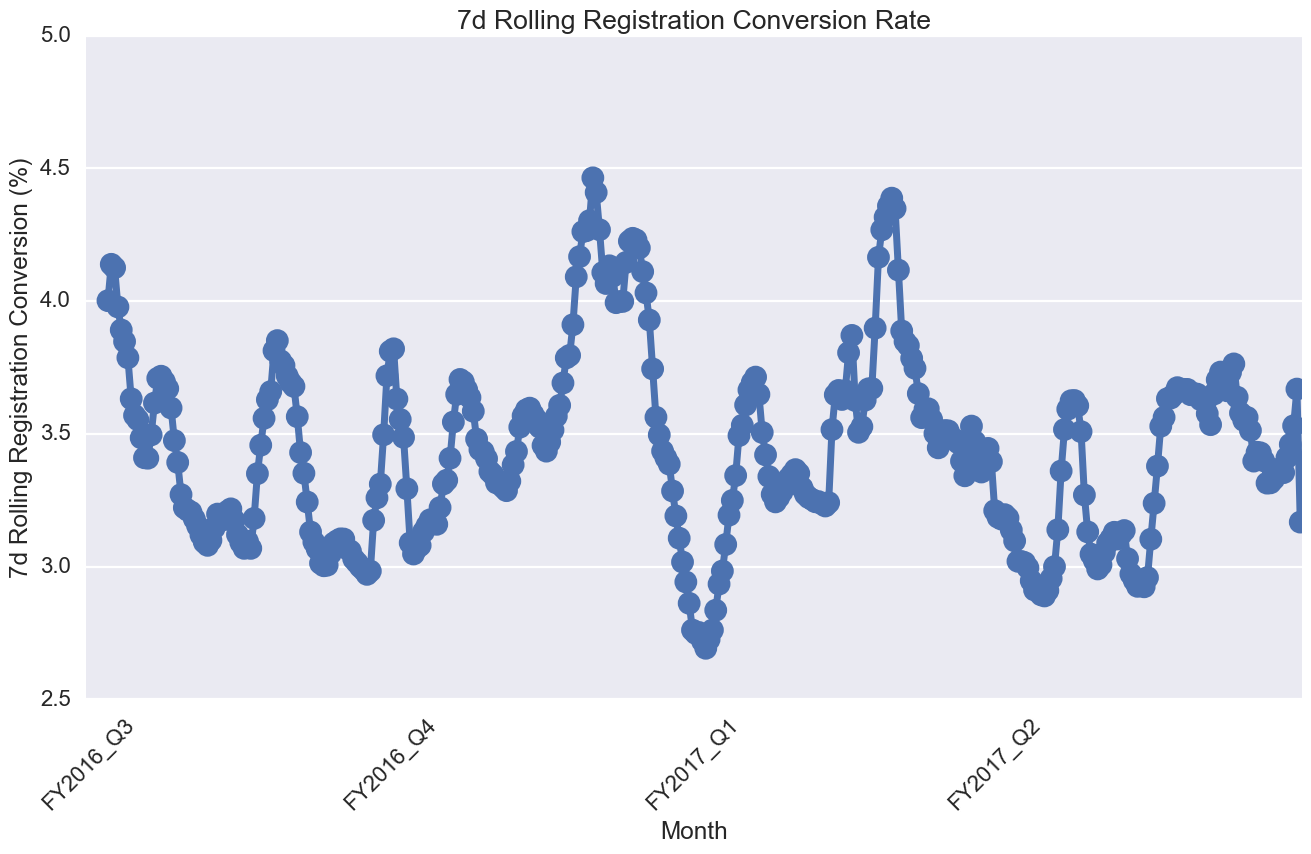

In [436]:
ax = sns.factorplot(data = pd.rolling_mean(enroll_reg_sessions_merge.set_index('date'), window=7).reset_index(),
                    x = 'date', y = 'reg_conversion_daily', 
               kind = 'point', size = 8, aspect = 2)
ax.set(xlabel='Month', ylabel='7d Rolling Registration Conversion (%)', 
       title = '7d Rolling Registration Conversion Rate',
       xticks=np.arange(0,365,91), xticklabels=quarters)
ax.set_xticklabels(rotation=45)


/Users/adleyhemphill/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=7,center=False).mean()
  if __name__ == '__main__':


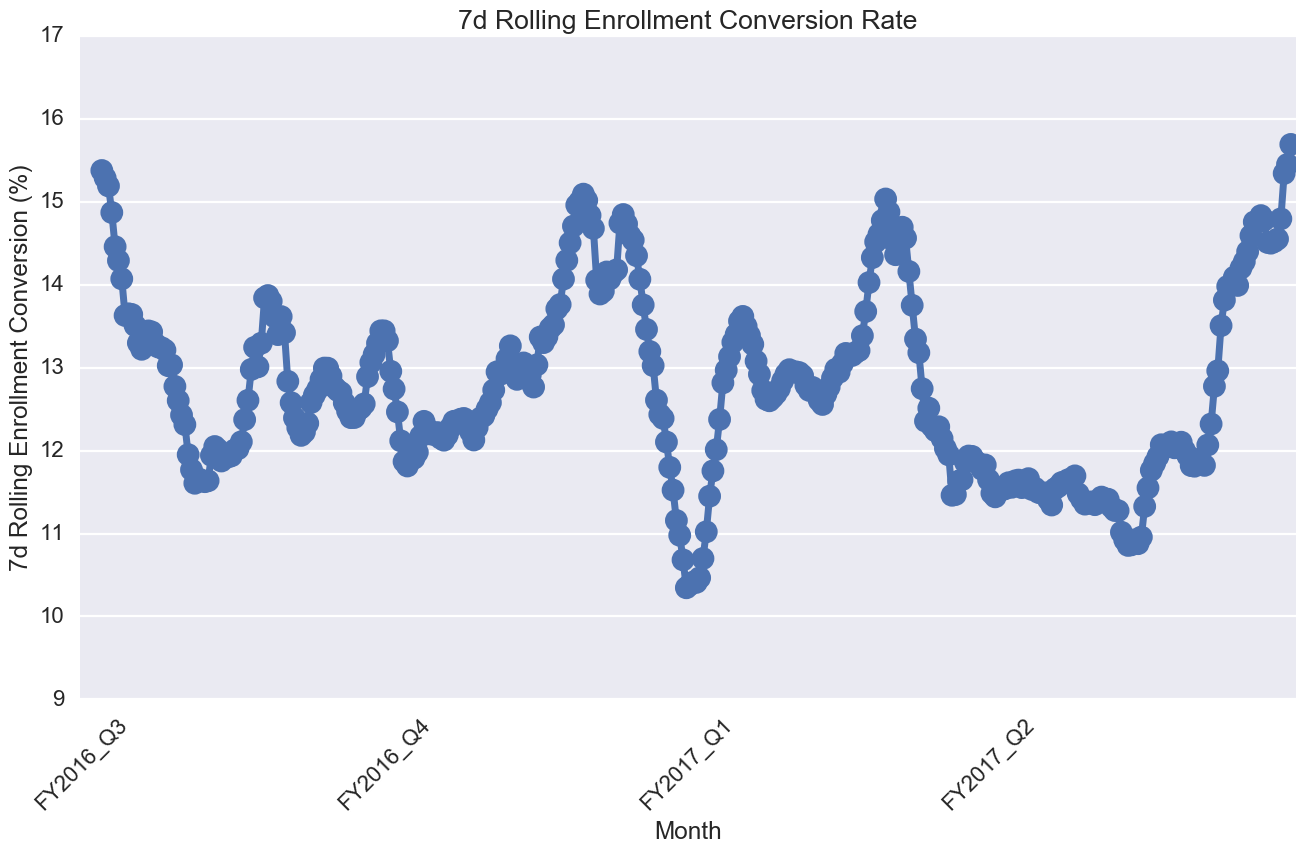

In [437]:
ax = sns.factorplot(data = pd.rolling_mean(enroll_reg_sessions_merge.set_index('date'), window=7).reset_index(),
                    x = 'date', y = 'enrollment_conversion_daily', 
               kind = 'point', size = 8, aspect = 2)
ax.set(xlabel='Month', ylabel='7d Rolling Enrollment Conversion (%)', 
       title = '7d Rolling Enrollment Conversion Rate',
       xticks=np.arange(0,365,91), xticklabels=quarters)
ax.set_xticklabels(rotation=45)
